In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
from pathlib import Path
import numpy as np
import polars as pl

root_dir = Path.cwd().parents[1]
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))
# print(root_dir)

from inference.BayesModel import (
    run_sampling,
    get_mean_from_sampler,
    build_distr_structure_from_params,
)
from inference.HierarchicalBayesModel import prior_structure, norm_ppf, halfnorm_ppf


df = pl.read_csv('../../../data/Treue/pone.0146500.s015.csv')
# df = pl.read_csv("../../../data/Treue/pone.0146500.s016.csv")

In [2]:
group_size = df.group_by(["cellId", "channelId", "acond", "angle"]).agg(
    pl.col("rate").count().alias("count")
)
# print(f"Number of entries in group: {group_size}")
group_size

cellId,channelId,acond,angle,count
str,i64,str,f64,u32
"""vlk-rTask3-cls-035-01+01""",1,"""uni2""",120.0,5
"""vlk-rTask1-har-018-01+01""",1,"""afix""",0.0,6
"""vlk-rTask1-cls-040-01+01""",1,"""ain""",240.0,7
"""vlk-rTask2-har-092-01+01""",2,"""afix""",150.0,5
"""vlk-rTask1-cls-030-02+01""",2,"""ain""",60.0,12
…,…,…,…,…
"""vlk-rTask1-har-102-04+01""",1,"""ain""",30.0,4
"""vlk-rTask1-har-070-01+02""",1,"""uni2""",270.0,4
"""vlk-rTask1-har-107-01+01""",1,"""uni2""",30.0,5


In [3]:
df.filter(pl.col("acond") == "uni2").group_by(["cellId", "channelId"]).agg(
    pl.col("rate").count().alias("count")
)

cellId,channelId,count
str,i64,u32
"""vlk-rTask3-cls-035-01+01""",1,63
"""vlk-rTask2-har-087-01+01""",2,48
"""vlk-rTask3-cls-039-01+01""",2,31
"""vlk-rTask2-har-091-01+02""",1,49
"""vlk-rTask1-har-105-01+01""",2,43
…,…,…
"""vlk-rTask3-har-112-02+02""",1,36
"""vlk-rTask3-cls-037-01+02""",2,46
"""vlk-rTask3-har-112-02+02""",2,36


In [4]:
# df.filter(pl.col("trialNum") == 9).filter(
#     pl.col("acond") == "uni2"
# )  # .group_by(["cellId", "channelId", "acond"]).agg(pl.col("rate").mean().alias("mean"))
unique_angles = sorted(
    df.filter(pl.col("acond") == "uni2").select("angle").unique().to_series().to_list()
)
print(unique_angles)

n_neurons = (
    df.filter(pl.col("acond") == "uni2")
    .group_by(["cellId", "channelId"])
    .agg(pl.col("rate").count().alias("count"))
).shape[0]

event_count = np.zeros((len(unique_angles), n_neurons))
for i, angle in enumerate(unique_angles):
    event_count[i, :] = (
        df.filter(pl.col("acond") == "uni2")
        .filter(pl.col("angle") == angle)
        .group_by(["cellId", "channelId", "acond"])
        .agg(pl.col("rate").mean())["rate"]
    )  # .alias("mean"))

[0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0]


In [5]:
# grouped_df.filter(pl.col("acond") == "uni2").filter(pl.col("angle") == 0).sort(
#     by="cellId"
# )

Condition: afix
Condition: ain
Condition: uni2


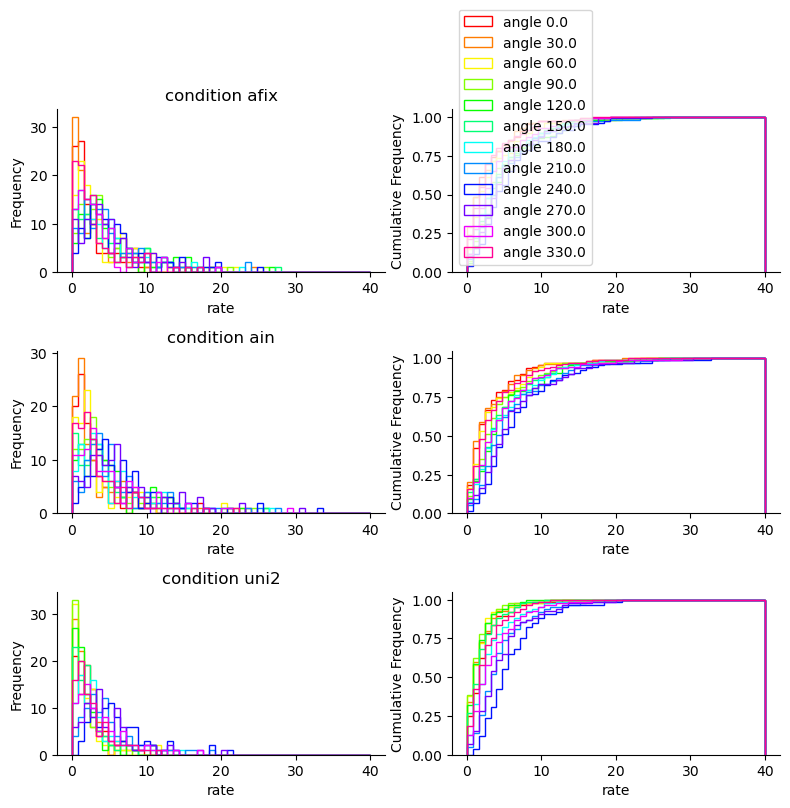

In [6]:
import numpy as np

grouped_df = df.group_by(["cellId", "channelId", "acond", "angle"]).agg(
    pl.col("rate").mean().alias("rate")
)


# To filter all entries where the `angle` column equals a specific value (e.g., 240.0):
unique_conditions = grouped_df["acond"].unique()
unique_angles = grouped_df["angle"].unique()
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
for i, cond in enumerate(unique_conditions):
    print(f"Condition: {cond}")
    df_cond = grouped_df.filter(pl.col("acond") == cond)
    # print(df.filter(pl.col("acond") == cond).describe())

    ax_pdf = fig.add_subplot(len(unique_conditions), 2, i * 2 + 1)
    ax_cdf = fig.add_subplot(len(unique_conditions), 2, i * 2 + 2)

    for angle in unique_angles:
        color = plt.cm.hsv(angle / 360.0)
        options = {
            "bins": np.linspace(0, 40, 51),
            "label": f"angle {angle}",
            "histtype": "step",
            "color": color,
        }
        rates = df_cond.filter(pl.col("angle") == angle)["rate"].to_numpy() / 6.0
        # print(rates.shape)
        ax_pdf.hist(rates, **options)
        ax_cdf.hist(rates, cumulative=True, density=True, **options)
        # plt.title(f"Histogram of rate for angle {angle}")
    ax_pdf.spines[["top", "right"]].set_visible(False)
    ax_cdf.spines[["top", "right"]].set_visible(False)
    plt.setp(ax_pdf, xlabel="rate", ylabel="Frequency")
    plt.setp(ax_cdf, xlabel="rate", ylabel="Cumulative Frequency")

    if i == 0:
        ax_cdf.legend()
    ax_pdf.set_title(f"condition {cond}")
plt.tight_layout()

In [ ]:
mode = "uni2"  # one of ain afix uni2
# mode = "afix"  # one of ain afix uni2
# mode = "ain"  # one of ain afix uni2
T = 6

prior = {}
# prior["gamma_0"] = prior_structure(norm_ppf, mean=2.0, sigma=0.5)
prior["gamma_pop0"] = prior_structure(
    halfnorm_ppf,
    loc=1.0,
    # mean=prior_structure(halfnorm_ppf, loc=1.0, scale=0.5),
    scale=0.5,
    # shape=(),
)
prior["delta_pop0"] = prior_structure(norm_ppf, mean=6.0, sigma=2.0)
# prior["nu_max_0"] = prior_structure(norm_ppf, mean=50.0, sigma=10.0)
prior["nu_max_pop0"] = prior_structure(
    None,
    value=[35.0],
)

res = {}

df_cond = grouped_df.filter(pl.col("acond") == mode)
for angle in unique_angles:
    spike_counts = (
        df_cond.filter(pl.col("angle") == angle)["rate"].to_numpy().astype(np.float64)
    )

    # print("shape:", spike_counts.shape)

    BM, results, sampler = run_sampling(
        spike_counts,
        T,
        mode="ultranest",
        n_live=100,
        correct_N=3,
        bias_to_expected_max=0,
        bias_to_mean=0,
        priors=prior,
        nP=12,
    )

    # mean = get_mean_from_sampler(sampler, BM.paramNames, mode="dynesty")
    # mean["nu_max_0"] = prior["nu_max_0"]["parameters"]["value"][0]

    # res[angle] = mean
    res[angle] = results

    # params = build_distr_structure_from_params(mean, BM.paramIn)
    # print(params)

In [7]:
a = np.zeros(12)
np.atleast_2d(a).shape

(1, 12)

In [8]:
event_count.shape

(12, 85)

In [9]:
mode = "uni2"  # one of ain afix uni2
# mode = "afix"  # one of ain afix uni2
# mode = "ain"  # one of ain afix uni2
T = 6

prior = {}
# prior["gamma_0"] = prior_structure(norm_ppf, mean=2.0, sigma=0.5)
prior["gamma_pop0"] = prior_structure(
    halfnorm_ppf, loc=1.0, scale=0.5, shape=(event_count.shape[0],)
)
# mean=prior_structure(halfnorm_ppf, loc=1.0, scale=0.5),
prior["delta_pop0"] = prior_structure(
    norm_ppf, mean=6.0, sigma=2.0, shape=(event_count.shape[0],)
)
# prior["nu_max_0"] = prior_structure(norm_ppf, mean=50.0, sigma=10.0)
prior["nu_max_pop0"] = prior_structure(
    None,
    value=[35.0],
)

res = {}

# df_cond = grouped_df.filter(pl.col("acond") == mode)
# for angle in unique_angles:
# spike_counts = (
#     df_cond.filter(pl.col("angle") == angle)["rate"].to_numpy().astype(np.float64)
# )

print("shape:", event_count.shape)

BM, results, sampler = run_sampling(
    event_count[np.newaxis, ...],
    T,
    mode="ultranest",
    n_live=400,
    correct_N=3,
    bias_to_expected_max=0,
    bias_to_mean=0,
    priors=prior,
    nP=12,
)

shape: (12, 85)


AssertionError: ('wrapped_params has the number of entries:', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]), ', expected', 2)

In [12]:
results.samples.shape

(32694, 24)

In [13]:
names = [f"gamma_{i}" for i in range(event_count.shape[0])]
names.extend([f"delta_{i}" for i in range(event_count.shape[0])])
names

['gamma_0',
 'gamma_1',
 'gamma_2',
 'gamma_3',
 'gamma_4',
 'gamma_5',
 'gamma_6',
 'gamma_7',
 'gamma_8',
 'gamma_9',
 'gamma_10',
 'gamma_11',
 'delta_0',
 'delta_1',
 'delta_2',
 'delta_3',
 'delta_4',
 'delta_5',
 'delta_6',
 'delta_7',
 'delta_8',
 'delta_9',
 'delta_10',
 'delta_11']

In [14]:
get_mean_from_sampler(results, names, mode="dynesty", output="list")

[2.006361898441466,
 2.070539493730876,
 2.071453479056745,
 1.9868383296865386,
 2.0607382369975036,
 2.0878606746978337,
 2.1045003633894352,
 2.3798381306059806,
 2.5712802983110614,
 2.130488928397322,
 2.115195460873167,
 2.0315388212869703,
 4.996319861454031,
 5.295439112563075,
 5.390469763778147,
 5.221096401280337,
 5.33165031823592,
 5.170398555929735,
 4.84697539071319,
 5.00392775042122,
 4.913461297964987,
 4.485307206843664,
 4.777388848346974,
 4.887974543310001]

(<Figure size 550x550 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='$x_{1}$', ylabel='$x_{2}$'>,
         <Axes: xlabel='$x_{2}$'>]], dtype=object))

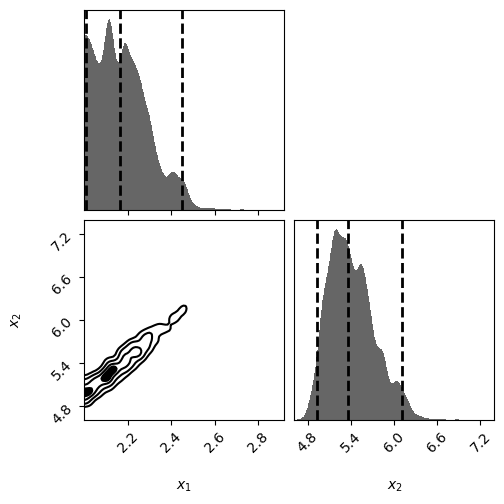

In [22]:
from dynesty import plotting as dyplot

dyplot.cornerplot(res[0])

In [ ]:
from DM_theory.functions import get_alpha_0, get_nu_bar

angle = 0
mean_list = get_mean_from_sampler(
    res[angle], BM.paramNames, mode="dynesty", output="list"
)
params = BM.get_params_from_p(np.array(mean_list), idx_sample=0)  # ,

alpha_0 = get_alpha_0(**params["distr"][0], nP=1)
alpha_0

nP=1


array([[0.0324656]])

In [36]:
BM.priors

{'gamma_0_mean': {'n': 1,
  'lower_hierarchy_level': False,
  'idx': 0,
  'transform': <function inference.HierarchicalBayesModel.HierarchicalModelDefinition.HierarchicalModel.set_prior_param.<locals>.<lambda>(x, params={'loc': 1.0, 'scale': 0.5}, fun=<function halfnorm_ppf at 0x7af38fabe670>)>},
 'gamma_0': {'n': 1,
  'lower_hierarchy_level': True,
  'idx': 1,
  'paramNames': ['mean'],
  'constants': {'sigma': 0.3},
  'idx_mean': 0,
  'transform': <function inference.HierarchicalBayesModel.HierarchicalModelDefinition.HierarchicalModel.set_prior_param.<locals>.<lambda>(x, params, fun=<function norm_ppf at 0x7af38fabe700>)>},
 'delta_0': {'n': 1,
  'lower_hierarchy_level': False,
  'idx': 2,
  'transform': <function inference.HierarchicalBayesModel.HierarchicalModelDefinition.HierarchicalModel.set_prior_param.<locals>.<lambda>(x, params={'mean': 6.0, 'sigma': 2.0}, fun=<function norm_ppf at 0x7af38fabe700>)>},
 'nu_max_0': {'n': 1,
  'lower_hierarchy_level': False,
  'idx': 3,
  'value'

mean params: {'distr': [{'gamma': array([2.17642995]), 'delta': array([5.41070363]), 'nu_max': array([35.])}]}
gamma_idx: 0 delta_idx: 1
distr params: {'gamma': array([2.17642995]), 'delta': array([5.41070363]), 'nu_max': array([35.])}
Angle 0.0: alpha_0 = [[0.02893294]], nu_bar = [2.47942913]
mean params: {'distr': [{'gamma': array([2.25503477]), 'delta': array([5.76561971]), 'nu_max': array([35.])}]}
gamma_idx: 0 delta_idx: 1
distr params: {'gamma': array([2.25503477]), 'delta': array([5.76561971]), 'nu_max': array([35.])}
Angle 30.0: alpha_0 = [[0.02731502]], nu_bar = [2.08374235]
mean params: {'distr': [{'gamma': array([2.24951032]), 'delta': array([5.86778468]), 'nu_max': array([35.])}]}
gamma_idx: 0 delta_idx: 1
distr params: {'gamma': array([2.24951032]), 'delta': array([5.86778468]), 'nu_max': array([35.])}
Angle 60.0: alpha_0 = [[0.02717378]], nu_bar = [1.86728821]
mean params: {'distr': [{'gamma': array([2.24431508]), 'delta': array([5.89540815]), 'nu_max': array([35.])}]}
ga

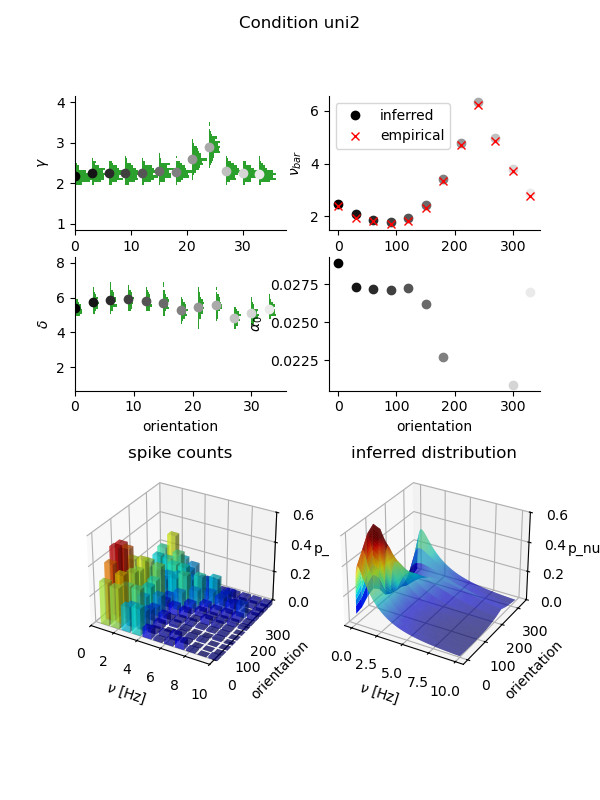

In [25]:
from inference.utils.utils import p_nu
from DM_theory.functions import get_alpha_0, get_nu_bar
from matplotlib import cm
from matplotlib.colors import Normalize

%matplotlib ipympl

fig = plt.figure(figsize=(6,8))
ax_gamma = fig.add_subplot(421)
ax_delta = fig.add_subplot(423)
ax_nu_bar = fig.add_subplot(422)
ax_alpha_0 = fig.add_subplot(424)



nu_cut = 10.

# params = build_distr_structure_from_params(res[0], BM.paramIn)
nu_array = np.linspace(
    0,
    # params["distr"][0]["nu_max"],
	nu_cut,
    1001,
    # np.ceil(params["distr"][0]["nu_max"] * T + 1.0).astype(int),
)

nbins = 11
spike_count_hist = np.zeros((nbins, len(res)))

p_nu_mesh = np.zeros((len(nu_array), len(res)))

gamma_arr = np.linspace(1, 4, 51)
delta_arr = np.linspace(1, 8, 51)

pop_idx = 0

for i, (angle, params) in enumerate(res.items()):

	color = plt.cm.grey(i / len(res))

	# print(BM.paramIn)
	mean = get_mean_from_sampler(res[angle], BM.paramNames, mode="dynesty")
	mean["nu_max_pop0"] = prior["nu_max_pop0"]["parameters"]["value"][0]

	mean_list = get_mean_from_sampler(res[angle], BM.paramNames, mode="dynesty", output="list")
	params = BM.get_params_from_p(np.array(mean_list),idx=(pop_idx,))#,idx_chain=0
	# print(mean)
	print("mean params:",params)
	# res[angle] = mean

	# params = build_distr_structure_from_params(mean, BM.paramIn)
	# print("params:",params)

	gamma_idx = BM.priors["gamma_pop0"]["idx"] + pop_idx
	delta_idx = BM.priors["delta_pop0"]["idx"] + pop_idx
	print("gamma_idx:", gamma_idx, "delta_idx:", delta_idx)

	ax_gamma.plot(angle/10, params["distr"][0]["gamma"], "o", color=color)
	ax_gamma.hist(res[angle]["samples"][:, gamma_idx], bins=gamma_arr, weights=res[angle].importance_weights(), density=True, orientation="horizontal",bottom=angle/10,color="tab:green")


	ax_delta.plot(angle/10, params["distr"][0]["delta"], "o", color=color)
	ax_delta.hist(res[angle]["samples"][:, delta_idx], bins=delta_arr, weights=res[angle].importance_weights(), density=True, orientation="horizontal",bottom=angle/10,color="tab:green")
	# params = build_distr_structure_from_params(res[angle], BM.paramIn)

	p_nu_mesh[:, i] = p_nu(nu_array, params)
	# ax_distr.plot(nu, p_nu(nu,params), label=f"Angle {angle}",color=color)

	print("distr params:", params["distr"][0])
	alpha_0 = get_alpha_0(**params["distr"][0],nP=1)  # This will print the alpha_0 value
	nu_bar = get_nu_bar(**params["distr"][0])  # This will print the nu
	print(f"Angle {angle}: alpha_0 = {alpha_0}, nu_bar = {nu_bar}")

	ax_alpha_0.plot(angle, alpha_0, "o", color=color)
	ax_nu_bar.plot(angle, nu_bar, "o", color=color,label="inferred" if i==0 else None)

	spike_counts = (
		df_cond.filter(pl.col("angle") == angle)["rate"].to_numpy().astype(np.float64)
	)

	spike_count_hist[:,i], bin_edges = np.histogram(spike_counts / T, bins=nbins, range=(0, nu_cut), density=True)

	# Optionally, store or plot hist for each angle if needed
	nu_bar_emp = spike_counts.mean() / T
	ax_nu_bar.plot(angle, nu_bar_emp, "rx",label="empirical" if i==0 else None)#, color=color)

plt.setp(ax_gamma, xlabel="orientation", ylabel="$\gamma$")
plt.setp(ax_delta, xlabel="orientation", ylabel="$\delta$")
plt.setp(ax_nu_bar, xlabel="orientation", ylabel="$\\nu_{bar}$")
plt.setp(ax_alpha_0, xlabel="orientation", ylabel="$\\alpha_0$")
for axx in [ax_gamma, ax_delta, ax_nu_bar, ax_alpha_0]:
	axx.spines[["top", "right"]].set_visible(False)
ax_nu_bar.legend()

ax_spike_counts = fig.add_subplot(223,projection='3d')
ax_distr = fig.add_subplot(224,projection='3d')


# 3D histogram of spike counts for each angle
xpos, ypos = np.meshgrid(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, unique_angles)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = (bin_edges[1] - bin_edges[0]) * 0.8
dy = (unique_angles[1] - unique_angles[0]) * 0.8 if len(unique_angles) > 1 else 1
dz = spike_count_hist.T.flatten()

# Normalize dz for coloring
norm_hist = Normalize(vmin=dz.min(), vmax=0.5)
colors_hist = cm.jet(norm_hist(dz))

ax_spike_counts.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, alpha=0.5, color=colors_hist, zsort='average')

plt.setp(ax_spike_counts, xlabel='$\\nu$ [Hz]', ylabel='orientation', zlabel='p_nu', xlim=[0, nu_cut],zlim=[0,0.6])
ax_spike_counts.set_title("spike counts")

X, Y = np.meshgrid(nu_array, unique_angles)
Z = p_nu_mesh.T  # shape: (len(angle_array), len(nu_array))

# Normalize Z for coloring
norm = Normalize(vmin=Z[np.isfinite(Z)].min(), vmax=0.5)
face_colors = cm.jet(norm(Z))

Z[:,0] =np.nan

surf = ax_distr.plot_surface(X, Y, Z, 
	facecolors=face_colors,
    edgecolor='none', 
    rstride=1, cstride=1, 
    antialiased=True)
surf.set_alpha(1.0)
plt.setp(ax_distr, xlabel='$\\nu$ [Hz]', ylabel='orientation', zlabel='p_nu',zlim=[0,0.6])
ax_distr.set_title("inferred distribution")
plt.suptitle(f"Condition {mode}")
plt.savefig(f"TreueData_analysis_{mode}_015.png", dpi=300)
# plt.show()

{'distr': [{'gamma': 1.5165431884263554, 'delta': 4.149551859722681, 'nu_max': 25.0}]}


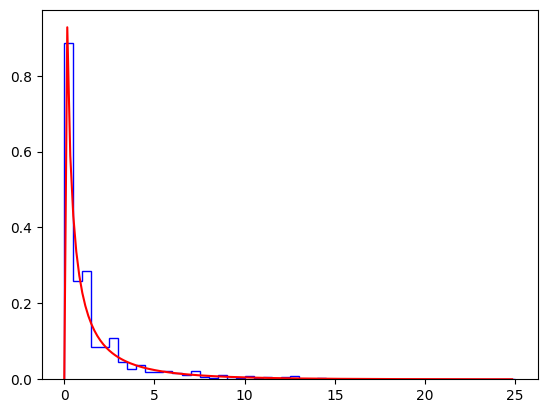

In [ ]:
mean["nu_max_0"] = prior["nu_max_0"]["parameters"]["value"][0]

plt.figure()
n_steps = 51
_ = plt.hist(
    spike_counts / 6,
    bins=np.linspace(0, mean["nu_max_0"], n_steps),
    histtype="step",
    label="angle 0",
    color="blue",
    density=True,
)

dnu = mean["nu_max_0"] / n_steps

params = build_distr_structure_from_params(mean, BM.paramIn)
print(params)

nu = np.linspace(0, mean["nu_max_0"], np.ceil(mean["nu_max_0"] * T + 1.0).astype(int))
plt.plot(nu, p_nu(nu, params), "r-", label="p_nu")


# from dynesty import utils as dyfunc, plotting as dyplot
# dyplot.cornerplot(
#     sampler.results,
#     color="dodgerblue",
#     # truths=truth_values,
#     show_titles=True,
# )
# plt.show(block=False)

In [ ]:
mode = "dynesty"
mean = {}
for i, key in enumerate(BM.paramNames):
    if mode == "dynesty":
        samp = sampler.results.samples[:, i]
        weights = sampler.results.importance_weights()
    else:
        samp = sampler.results["weighted_samples"]["points"][:, i]
        weights = sampler.results["weighted_samples"]["weights"]

    mean[key] = (samp * weights).sum()
    print(f"{key} mean: {mean[key]}")

gamma_0 mean: 1.5144112832857677
delta_0 mean: 4.185123503482691
nu_max_0 mean: 27.83969998051562


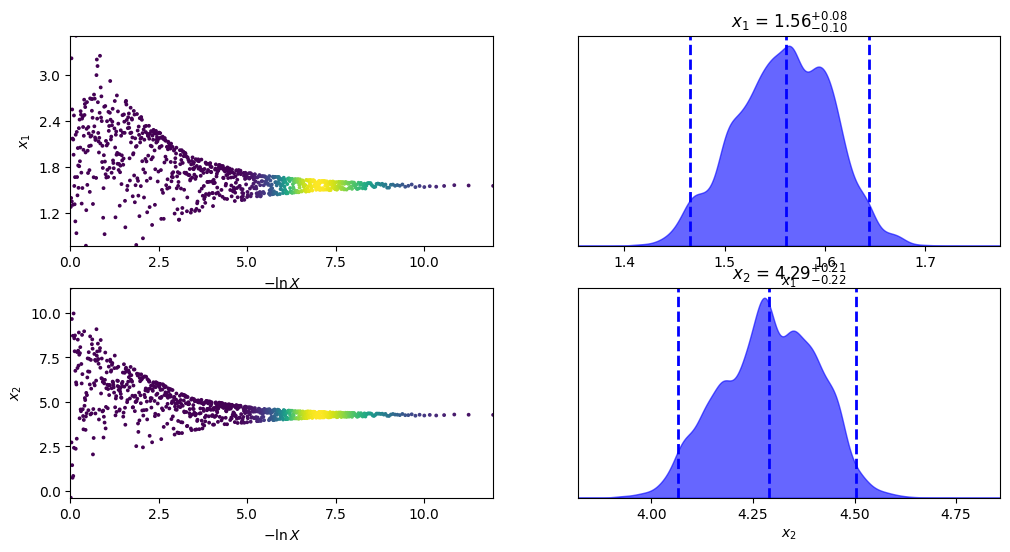

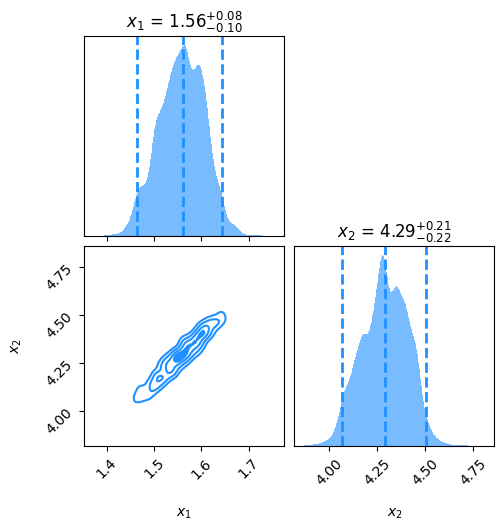

In [ ]:
dyplot.traceplot(
    sampler.results,
    # truths=truth_values,
    truth_color="black",
    show_titles=True,
    trace_cmap="viridis",
)
plt.show(block=False)
dyplot.cornerplot(
    sampler.results,
    color="dodgerblue",
    # truths=truth_values,
    show_titles=True,
)
plt.show(block=False)

In [58]:
BM.binom[0]["log_binomial_coefficient"][600]

835.575718826994

In [ ]:
from scipy.special import binom as sp_binom, comb
from scipy import special, exp, log

lgam = special.gammaln


def log_binomial(n, k):
    return lgam(n + 1) - lgam(n - k + 1) - lgam(k + 1)


# binom = sp_binom(BM.data['nNeurons'][0],np.arange(BM.data['nNeurons'][0]+1))
# binom = sp_binom(BM.data['nNeurons'][0],400)

binom = log_binomial(BM.data["nNeurons"][0], np.arange(10))
print(binom)

# binom = comb(BM.data['nNeurons'][0],400,exact=True)
# # print(np.log(binom))
# print(binom)
# binom[800:900]

[ 0.          7.09920174 13.5044302  19.50336676 25.21379378 30.70024909
 36.003554   41.15187869 46.16584178 51.06119092]


In [63]:
p_in = np.array([1.7, 3.9])

my_likelihood = BM.set_logl(
    vectorized=vectorized,
    correct_N=0,
    bias_to_expected_max=0,
    bias_to_mean=0,
    biological=False,
)
my_likelihood(p_in)

-1181.8931599756434

In [35]:
BM.priors

{'gamma_0': {'n': 1,
  'idx': 0,
  'transform': <function inference.HierarchicalModelDefinition.HierarchicalModel.set_prior_param.<locals>.<lambda>(x, params={'mean': 2.0, 'sigma': 0.5}, fun=<function <lambda> at 0x709b9d0203a0>)>},
 'delta_0': {'n': 1,
  'idx': 1,
  'transform': <function inference.HierarchicalModelDefinition.HierarchicalModel.set_prior_param.<locals>.<lambda>(x, params={'mean': 6.0, 'sigma': 2.0}, fun=<function <lambda> at 0x709b9d0203a0>)>},
 'nu_max_0': {'n': 1, 'idx': 2, 'value': [25.0], 'transform': None}}